# HSCT survival: XGBoost survival:cox objective

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

import configuration as config
import functions.helper as helper_funcs

notebook_num='04.2'
gpu=0

# Data files
datasets_file=f'{config.PROCESSED_DATA}/02.1-dataset_definitions.pkl'
coxph_survival_file=f'{config.PROCESSED_DATA}/02.1-coxPH_survival.pkl'
weibullaft_survival_file=f'{config.PROCESSED_DATA}/02.2-weibullAFT_survival.pkl'
learned_efs_file=f'{config.PROCESSED_DATA}/02.4-learned_efs.pkl'

## 1. Load data

In [ ]:
# Read the dataset metadata
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

# Load one of the datasets
with open(datasets['Nominal one-hot/ordinal encoded, NANs imputed'], 'rb') as input_file:
    data_dict=pickle.load(input_file)

print('Data dictionary contains:\n')
for key, value in data_dict.items():
    print(f' {key}: {type(value)}')

# Load Cox Proportional Hazard model features
with open(coxph_survival_file, 'rb') as input_file:
    coxph_features=pickle.load(input_file)

print('\nCox PH features:\n')
for key, value in coxph_features.items():
    print(f' {key}: {type(value)}')

# Load Weibull Accelerated Failure Time model features
with open(weibullaft_survival_file, 'rb') as input_file:
    weibullaft_features=pickle.load(input_file)

print('\nWeibull AFT features:\n')
for key, value in weibullaft_features.items():
    print(f' {key}: {type(value)}')

# Load learned efs features
with open(learned_efs_file, 'rb') as input_file:
    learned_efs_features=pickle.load(input_file)

print('\nLearned EFS features:\n')
for key, value in learned_efs_features.items():
    print(f' {key}: {type(value)}')

Data dictionary contains:

 Training features: <class 'pandas.core.frame.DataFrame'>
 Training labels: <class 'pandas.core.frame.DataFrame'>
 Training IDs: <class 'list'>
 Training race group: <class 'list'>
 Testing features: <class 'pandas.core.frame.DataFrame'>
 Testing labels: <class 'pandas.core.frame.DataFrame'>
 Testing IDs: <class 'list'>
 Testing race group: <class 'list'>

Cox PH features:

 Training survival: <class 'list'>
 Training partial hazard: <class 'list'>
 Testing survival: <class 'list'>
 Testing partial hazard: <class 'list'>

Weibull AFT features:

 Training survival: <class 'list'>
 Training expectation: <class 'list'>
 Testing survival: <class 'list'>
 Testing expectation: <class 'list'>

Learned EFS features:

 Training efs probability: <class 'numpy.ndarray'>
 Testing efs probability: <class 'numpy.ndarray'>


## 2. Data preparation

### 2.1. Add survival model features

In [ ]:
training_features_df=data_dict['Training features']
training_features_df['CoxPH survival']=coxph_features['Training survival']
training_features_df['CoxPH partial hazard']=coxph_features['Training partial hazard']
training_features_df['WeibullAFT survival']=weibullaft_features['Training survival']
training_features_df['WeibullAFT expectation']=weibullaft_features['Training expectation']

testing_features_df=data_dict['Testing features']
testing_features_df['CoxPH survival']=coxph_features['Testing survival']
testing_features_df['CoxPH partial hazard']=coxph_features['Testing partial hazard']
testing_features_df['WeibullAFT survival']=weibullaft_features['Testing survival']
testing_features_df['WeibullAFT expectation']=weibullaft_features['Testing expectation']

training_features_df.head().transpose()

,0,1,2,3,4
psych_disturb_1.0,0.000000,0.000000,0.000000,0.000000,0.000000
psych_disturb_2.0,0.000000,0.000000,0.000000,0.000000,1.000000
diabetes_1.0,1.000000,0.000000,0.000000,1.000000,0.000000
diabetes_2.0,0.000000,0.000000,0.000000,0.000000,1.000000
tbi_status_1.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
age_at_hct,45.076000,40.851000,34.568000,52.419000,55.890000
CoxPH survival,0.243637,0.363744,0.516802,0.194666,0.388247
CoxPH partial hazard,1.880348,1.346671,0.878995,2.179151,1.259862
WeibullAFT survival,0.063881,0.099494,0.268041,0.013788,0.146418


### 2.2. Add learned EFS features

In [4]:
training_features_df['learned_efs']=learned_efs_features['Training efs probability']
testing_features_df['learned_efs']=learned_efs_features['Testing efs probability']

training_features_df.head().transpose()

,0,1,2,3,4
psych_disturb_1.0,0.000000,0.000000,0.000000,0.000000,0.000000
psych_disturb_2.0,0.000000,0.000000,0.000000,0.000000,1.000000
diabetes_1.0,1.000000,0.000000,0.000000,1.000000,0.000000
diabetes_2.0,0.000000,0.000000,0.000000,0.000000,1.000000
tbi_status_1.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
CoxPH survival,0.243637,0.363744,0.516802,0.194666,0.388247
CoxPH partial hazard,1.880348,1.346671,0.878995,2.179151,1.259862
WeibullAFT survival,0.063881,0.099494,0.268041,0.013788,0.146418
WeibullAFT expectation,46.464758,59.920349,135.041976,24.464473,78.127198


### 2.3. Load labels, race group and ID

In [5]:
training_labels_df=data_dict['Training labels']
training_labels_df['efs_time']=np.log(training_labels_df['efs_time'])
training_race_groups=data_dict['Training race group']
training_ids=data_dict['Training IDs']

testing_labels_df=data_dict['Testing labels']
testing_labels_df['efs_time']=np.log(testing_labels_df['efs_time'])
testing_race_groups=data_dict['Testing race group']
testing_ids=data_dict['Testing IDs']

### 2.4. Right censoring

In [6]:
censored_efs_time=[]

for _, row in training_labels_df.iterrows():
    if row['efs'] == 0:
        censored_efs_time.append(-row['efs_time'])
    elif row['efs'] != 0:
        censored_efs_time.append(row['efs_time'])

training_labels_df['efs_time']=censored_efs_time

censored_efs_time=[]

for _, row in testing_labels_df.iterrows():
    if row['efs'] == 0:
        censored_efs_time.append(-row['efs_time'])
    elif row['efs'] != 0:
        censored_efs_time.append(row['efs_time'])

testing_labels_df['efs_time']=censored_efs_time
training_labels_df.head(20)

,efs,efs_time
0,1.0,0.761740
1,0.0,-4.662911
2,0.0,-3.549244
3,1.0,1.940754
4,1.0,1.712175
5,0.0,-4.125439
6,1.0,1.761816
7,1.0,1.492230
8,0.0,-3.168003
9,1.0,1.948621


## 3. XGBoost model

### 3.1. Training

In [7]:
models={}
predictions={}

hyperparameters={
    'objective': 'survival:cox',
    'eval_metric': 'rmse',
    'seed': 315,
    'learning_rate': 0.01,
    'max_depth': 6,
    'gamma': 0.01,
    'subsample': 0.5
}

if gpu != None:
    hyperparameters['gpu_id']=gpu
    hyperparameters['tree_method']='gpu_hist'


dtraining=xgb.DMatrix(
    training_features_df,
    label=training_labels_df['efs_time']
)
dtesting=xgb.DMatrix(
    testing_features_df,
    label=testing_labels_df['efs_time']
)

tree_model=xgb.train(
    hyperparameters,
    dtraining,
    num_boost_round=5000,
    evals=[(dtesting, 'testing')],
    early_stopping_rounds=500,
    verbose_eval=0
)

# Make training predictions
training_predictions=tree_model.predict(dtraining)

# Make testing predictions
testing_predictions=tree_model.predict(dtesting)

### 3.2. Prediction plots

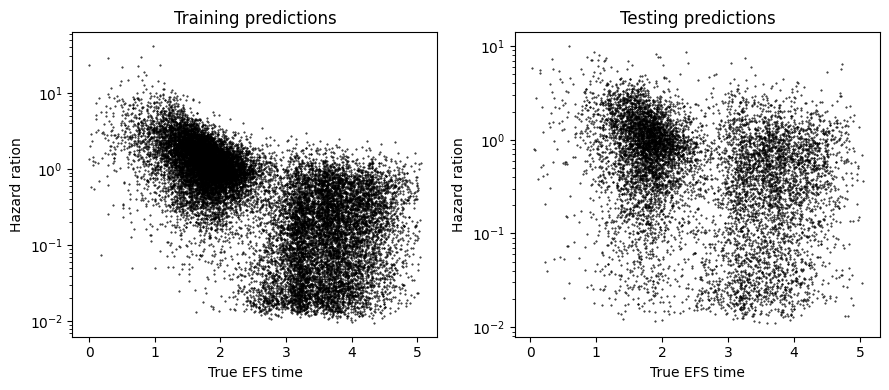

In [8]:
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

axs[0].set_title('Training predictions')
axs[0].scatter(
    abs(training_labels_df['efs_time']), 
    training_predictions,
    c='black',
    s=0.2,
)

axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Hazard ration')
axs[0].set_yscale('log')

axs[1].set_title('Testing predictions')
axs[1].scatter(
    abs(testing_labels_df['efs_time']), 
    testing_predictions,
    s=0.2,
    c='black'
)
axs[1].set_xlabel('True EFS time')
axs[1].set_ylabel('Hazard ration')
axs[1].set_yscale('log')

fig.tight_layout()
fig.show()

### 3.3. Scoring

In [9]:
score_results=helper_funcs.score_predictions(
        'Training predictions',
        -training_predictions,
        abs(training_labels_df['efs_time'].values),
        training_labels_df['efs'].values,
        training_race_groups,
        training_ids
)

score_results=helper_funcs.score_predictions(
        'Testing predictions',
        -testing_predictions,
        abs(testing_labels_df['efs_time'].values),
        testing_labels_df['efs'].values,
        testing_race_groups,
        testing_ids,
        results=score_results
)

score_results_df=pd.DataFrame(score_results)
score_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,Training predictions,3.712989,0.829035,0.810522
1,Testing predictions,3.623038,0.657708,0.644038
